# Using the WFPT Class Factory

We have designed HSSM to be flexible. The users can use arbitrary log-likelihood functions that take arbitrary numbers of parameters with HSSM. The functions do not have to be LANs. Nor do they have to be differentiable (although differentiable likelihood functions are desirable for use with NUTS samplers). This notebook demonstrates how to use the WFPT class factories to generate arbitrary `pm.Distribution` classes for use with either PyMC or Bambi.

In [2]:
import multiprocessing as mp

import aesara
import aesara.tensor as at
import arviz as az
import jax
import numpy as np
import numpyro
import pymc as pm
from pymc import sampling_jax
import timeit

# WFPT and LAN are two factory classes
from hssm.wfpt import WFPT, LAN
import ssms.basic_simulators

numpyro.set_host_device_count(jax.local_device_count())

## Creating basic `WFPT` distibution 
The WFPT class can create different types of log-likelihoods. The basic log-likelihood is Wiener first-passage time (WFPT)  using
    the method and implementation of Navarro & Fuss, 2009. 
    
In order to use basic likelihood, you need to set `model ='base'` in `make_lan_distribution` method. 


In [13]:
WFPT_base = WFPT.make_ssm_distribution(
    model="base",
    list_params=["v", "a", "z", "t", "sv"],
)

In [14]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)

In [15]:
aesara.config.floatX = "float32"
start = timeit.default_timer()

with pm.Model() as m_angle:
    v = pm.Uniform("v", -3.0, 3.0)
    a = pm.Uniform("a", 0.3, 2.5)
    z = pm.Uniform("z", 0.1, 0.9)
    t = pm.Uniform("t", 0.0, 2.0)
    sv = pm.Uniform("sv", -0.1, 1.2)

    rt = WFPT_base(
        name="rt",
        v=v,
        a=a,
        z=z,
        t=t,
        sv=sv,
        observed=obs_angle["rts"][:, 0] * obs_angle["choices"][:, 0],
    )

    # mp_ctx fixes parallel sampling on M1 Macs
    trace_angle_nuts = pm.sample(
        cores=2, draws=500, tune=500, mp_ctx=mp.get_context("fork")
    )
stop = timeit.default_timer()
print("Time: ", stop - start)

Time:  468.3902017500001


/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/aomar7/opt/anacon

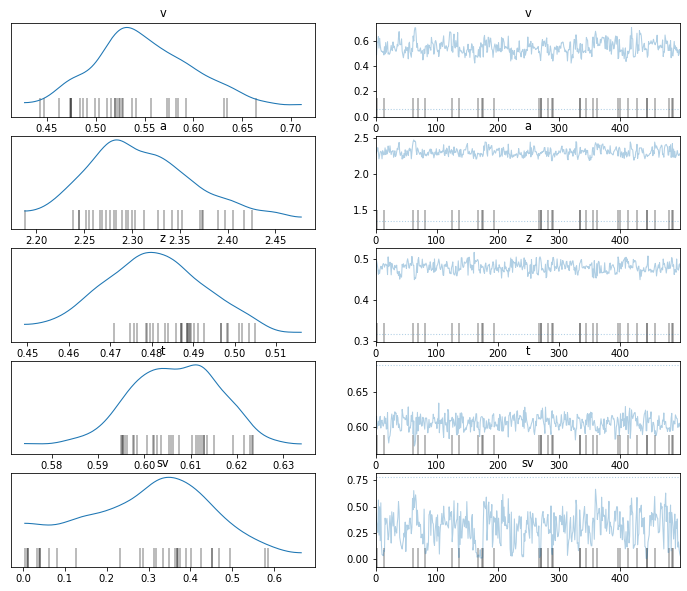

In [30]:
az.plot_trace(trace_angle_nuts);

In [27]:
aesara.config.floatX = "float32"
start = timeit.default_timer()

with pm.Model() as m_angle:
    v = pm.Uniform("v", -3.0, 3.0)
    a = pm.Uniform("a", 0.3, 2.5)
    z = pm.Uniform("z", 0.1, 0.9)
    t = pm.Uniform("t", 0.0, 2.0)
    sv = pm.Uniform("sv", -0.1, 1.2)

    rt = WFPT_base(
        name="rt",
        v=v,
        a=a,
        z=z,
        t=t,
        sv=sv,
        observed=obs_angle["rts"][:, 0] * obs_angle["choices"][:, 0],
    )

    # mp_ctx fixes parallel sampling on M1 Macs
    trace_angle_nuts_jax = pm.sampling_jax.sample_numpyro_nuts(
        chains=2,
        draws=500,
        tune=500,
    )
stop = timeit.default_timer()
print("Time: ", stop - start)

Compiling...
Compilation time =  0:00:00.540700
Sampling...


/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/aesara/link/jax/dispatch/elemwise.py:35: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax_op(x, axis=axis).astype(acc_dtype)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Sampling time =  0:00:24.251588
Transforming variables...
Transformation time =  0:00:00.057245
Computing Log Likelihood...
Log Likelihood time =  0:00:00.374458
Time:  25.25544274999993


array([[<AxesSubplot:title={'center':'v'}>,
        <AxesSubplot:title={'center':'v'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'z'}>],
       [<AxesSubplot:title={'center':'t'}>,
        <AxesSubplot:title={'center':'t'}>],
       [<AxesSubplot:title={'center':'sv'}>,
        <AxesSubplot:title={'center':'sv'}>]], dtype=object)

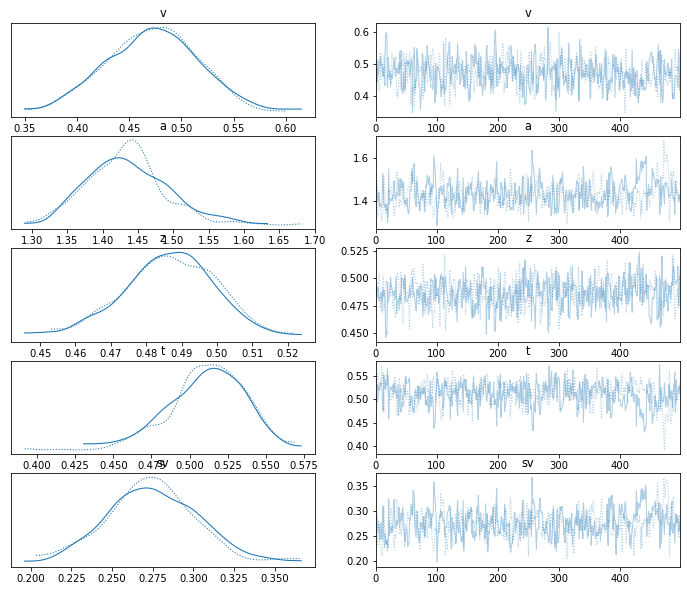

In [28]:
az.plot_trace(trace_angle_nuts_jax)

## Using the `LAN` factory class for LAN related functionalities

The LAN class has factory methods that produces LAN related log-likelihoods using either `aesara` or `jax` backend.


### LAN using the JAX backend:

`LAN.make_jax_logp_from_onnx` takes an onnx model or the path to it and a number of parameters and produces 3 jax functions: one for the log-likelihood, one for the gradient of the log-likelihood, and one log-likelihood that is not jitted (so it can be unwrapped during JAX sampling).

#### Making JAX LAN functions from onnx models:

In [2]:
logp, logp_grad, logp_nojit = LAN.make_jax_logp_funcs_from_onnx("test.onnx", n_params=5)

All these functions take a vector and an arbirary number of parameters and computes the log-likelihood.

In [3]:
logp(np.ones(1000), *([1.0] * 5))

DeviceArray(3887.73633209, dtype=float64)

In [4]:
logp_grad(np.ones(1000), *([1.0] * 5))

(DeviceArray(300.39628854, dtype=float64, weak_type=True),
 DeviceArray(-626.80957384, dtype=float64, weak_type=True),
 DeviceArray(17390.32921241, dtype=float64, weak_type=True),
 DeviceArray(-137150.44377326, dtype=float64, weak_type=True),
 DeviceArray(1115.6818593, dtype=float64, weak_type=True))

#### Wrapping JAX LAN functions in aesara `Op`s

`LAN.make_jax_logp_ops` takes the outputs from `LAN.make_jax_logp_funcs_from_onnx` and wrap the 3 JAX functions in aesara `op`s. It also takes care of registering the unjitted JAX function with `jax_funcify` so it can be unwrapped in JAX-backend sampling.

In [5]:
logp_op = LAN.make_jax_logp_ops(logp, logp_grad, logp_nojit)
logp_op(np.ones(1000), *([1.0] * 5)).eval()

array(3887.73633209)

In [6]:
# Testing aesara.grad on this Op

v_1 = at.as_tensor_variable(1.0)
x = logp_op(np.ones(10), *[v_1, 1.0, 1.0, 1.0, 1.0])
aesara.grad(x, wrt=v_1).eval()

array(3.00396276)

#### Create a LAN distribution directly from `WFPT.make_lan_distribution`

`WFPT.make_lan_distribution` conveniently wraps all steps above and create a `pymc.Distribution`.

In [19]:
LAN_jax = WFPT.make_wfpt_distribution(
    model="test.onnx",
    backend="jax",
    list_params=["v", "a", "z", "t", "theta"],
)

### LAN using the aesara backend

As an alternative, the onnx model can also be translated directly into aesara:

In [8]:
logp_aesara = LAN.make_aesara_logp("test.onnx")
logp_aesara

<function hssm.wfpt.lan.LAN.make_aesara_logp.<locals>.logp(data: 'np.ndarray', *dist_params) -> 'ArrayLike'>

In [9]:
logp_aesara(np.ones(10), *([1.0] * 5)).eval()

array(38.87736332)

#### Create a LAN distribution directly from `WFPT.make_lan_distribution`

When `backend` is not set or to `"aesara"`, `WFPT.make_lan_distribution` will make a log-likelihood function with aesara and make a `pymc.Distribution` with aesara backend.

In [18]:
LAN_aesara = WFPT.make_ssm_distribution(
    model="test.onnx",
    backend="aesara",
    list_params=["v", "a", "z", "t", "theta"],
)

### Create arbitrary WFPT distributions

The `WFPT` factory class provides a general `make_distribution` class method to generate an arbitrary `pymc.Distribution` from user-supplied log-likelihood functions and `RandomVariable` `Op`s.

```python
arbitrary_distribution = WFPT.make_distribution(
    loglike=some_likelihood_func,
    rv=some_RandomVariable_Op,
    list_params=["v", "a", "z", "t", "theta"] # A list of str specifying the names and order of the parameters
)
```

## Sampling from arbitrary LAN distributions

The class produced by the factory classes can then be used for sampling with `PyMC`

In [20]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)

#### Sampling with PyMC from LAN distribution with JAX backend

In [21]:
aesara.config.floatX = "float32"

start = timeit.default_timer()
with pm.Model() as m_angle:
    v = pm.Uniform("v", -3.0, 3.0)
    a = pm.Uniform("a", 0.3, 2.5)
    z = pm.Uniform("z", 0.1, 0.9)
    t = pm.Uniform("t", 0.0, 2.0)
    theta = pm.Uniform("theta", -0.1, 1.2)

    rt = LAN_jax(
        name="rt",
        v=v,
        a=a,
        z=z,
        t=t,
        theta=theta,
        observed=obs_angle["rts"][:, 0] * obs_angle["choices"][:, 0],
    )

    # mp_ctx fixes parallel sampling on M1 Macs
    trace_angle_nuts_jax_wrapped = pm.sample(
        cores=2, draws=500, tune=500, mp_ctx=mp.get_context("forkserver")
    )
stop = timeit.default_timer()
print("Time: ", stop - start)

Time:  50.56962612500001


array([[<AxesSubplot:title={'center':'v'}>,
        <AxesSubplot:title={'center':'v'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'z'}>],
       [<AxesSubplot:title={'center':'t'}>,
        <AxesSubplot:title={'center':'t'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

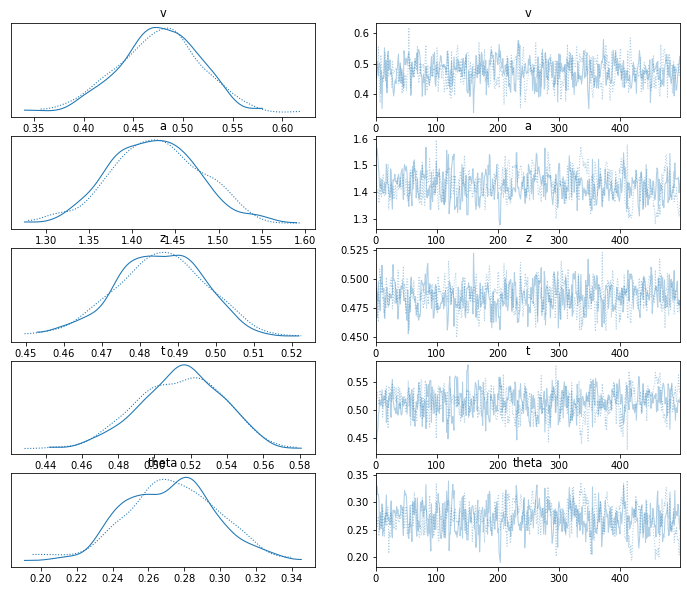

In [22]:
az.plot_trace(trace_angle_nuts_jax_wrapped)

#### Sampling with JAX and numpyro from LAN distribution with JAX backend

In [24]:
# This forces float32 in jax
from jax.config import config

config.update("jax_enable_x64", False)
start = timeit.default_timer()

with pm.Model() as m_angle:
    v = pm.Uniform("v", -3.0, 3.0)
    a = pm.Uniform("a", 0.3, 2.5)
    z = pm.Uniform("z", 0.1, 0.9)
    t = pm.Uniform("t", 0.0, 2.0)
    theta = pm.Uniform("theta", -0.1, 1.2)

    rt = LAN_jax(
        name="rt",
        v=v,
        a=a,
        z=z,
        t=t,
        theta=theta,
        observed=obs_angle["rts"][:, 0] * obs_angle["choices"][:, 0],
    )

    # No need to fix parallel sampling on M1 Macs
    trace_angle_nuts_jax_numpyro = pm.sampling_jax.sample_numpyro_nuts(
        chains=2, draws=500, tune=500, chain_method="parallel"
    )

stop = timeit.default_timer()
print("Time: ", stop - start)

Compiling...
Compilation time =  0:00:00.616324
Sampling...


/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/aesara/link/jax/dispatch/elemwise.py:35: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax_op(x, axis=axis).astype(acc_dtype)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Sampling time =  0:00:26.050470
Transforming variables...
Transformation time =  0:00:00.123274
Computing Log Likelihood...
Log Likelihood time =  0:00:01.143951
Time:  27.9828318750001


array([[<AxesSubplot: title={'center': 'v'}>,
        <AxesSubplot: title={'center': 'v'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 't'}>,
        <AxesSubplot: title={'center': 't'}>],
       [<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

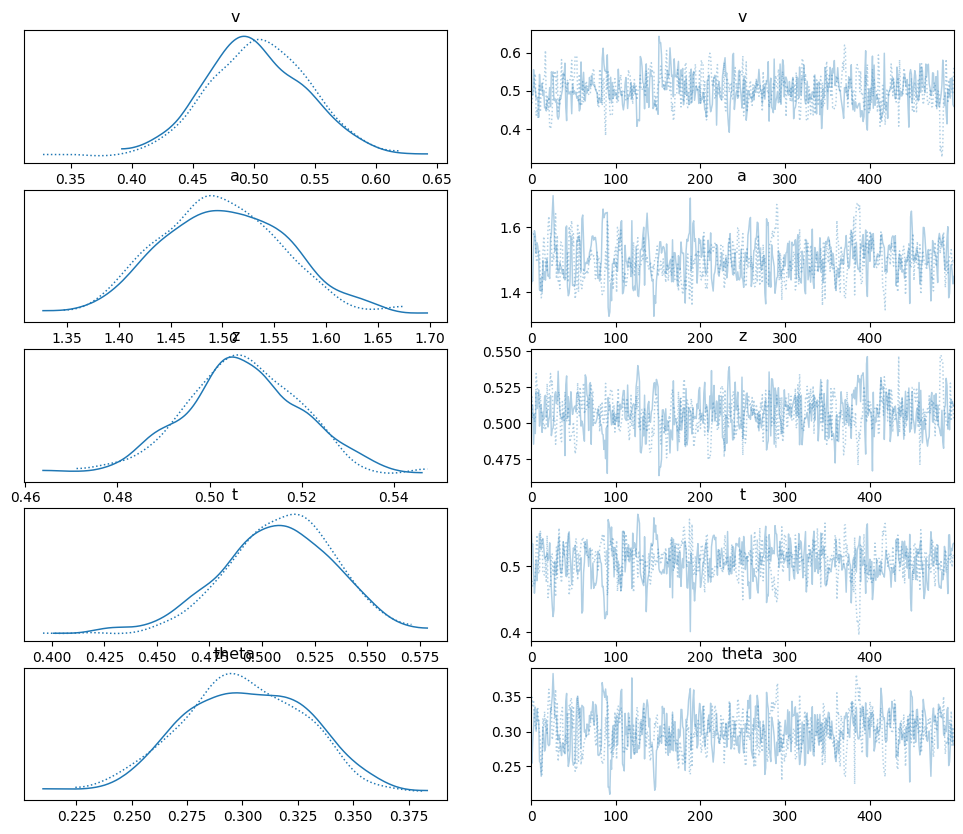

In [15]:
az.plot_trace(trace_angle_nuts_jax_numpyro)

#### Sampling with PyMC from LAN distribution with aesara backend

In [25]:
start = timeit.default_timer()

with pm.Model() as m_angle:
    v = pm.Uniform("v", -3.0, 3.0)
    a = pm.Uniform("a", 0.3, 2.5)
    z = pm.Uniform("z", 0.1, 0.9)
    t = pm.Uniform("t", 0.0, 2.0)
    theta = pm.Uniform("theta", -0.1, 1.2)

    rt = LAN_aesara(
        name="rt",
        v=v,
        a=a,
        z=z,
        t=t,
        theta=theta,
        observed=obs_angle["rts"][:, 0] * obs_angle["choices"][:, 0],
    )

    trace_angle_nuts_aesara = pm.sample(
        cores=2, draws=500, tune=500, mp_ctx=mp.get_context("forkserver")
    )
stop = timeit.default_timer()
print("Time: ", stop - start)

Time:  54.421431125000026


array([[<AxesSubplot: title={'center': 'v'}>,
        <AxesSubplot: title={'center': 'v'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 't'}>,
        <AxesSubplot: title={'center': 't'}>],
       [<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

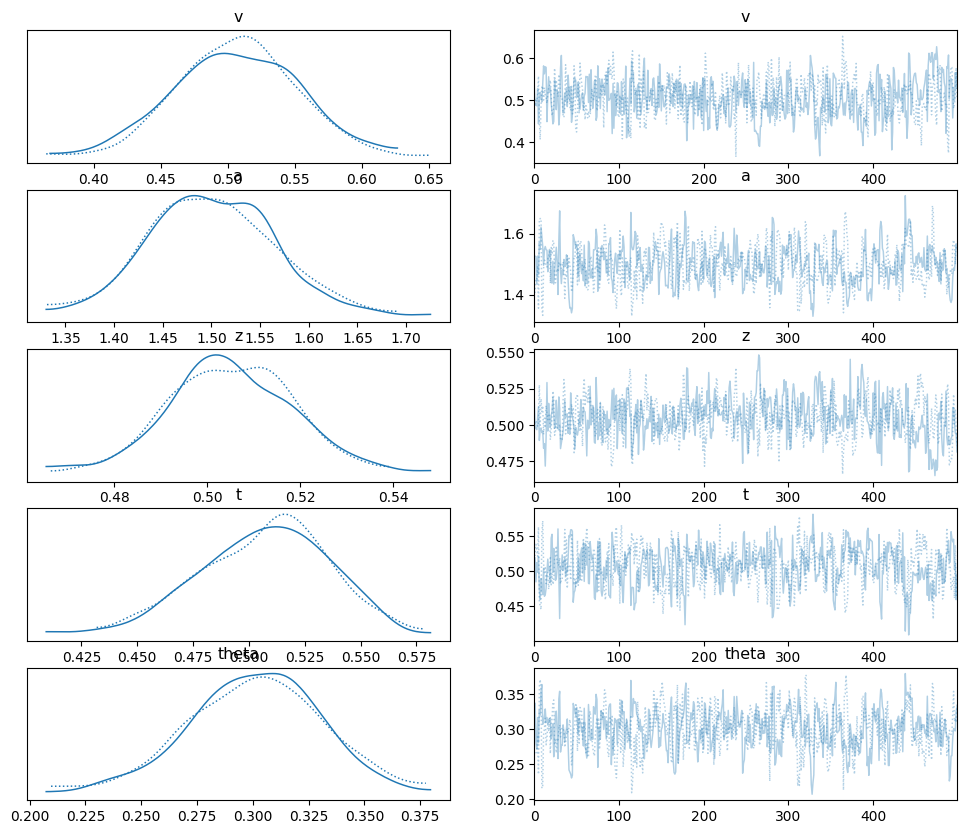

In [17]:
az.plot_trace(trace_angle_nuts_aesara)

#### Sampling with JAX and numpyro from LAN distribution with aesara backend

In [26]:
start = timeit.default_timer()

with pm.Model() as m_angle:
    v = pm.Uniform("v", -3.0, 3.0)
    a = pm.Uniform("a", 0.3, 2.5)
    z = pm.Uniform("z", 0.1, 0.9)
    t = pm.Uniform("t", 0.0, 2.0)
    theta = pm.Uniform("theta", -0.1, 1.2)

    rt = LAN_aesara(
        name="rt",
        v=v,
        a=a,
        z=z,
        t=t,
        theta=theta,
        observed=obs_angle["rts"][:, 0] * obs_angle["choices"][:, 0],
    )

    trace_angle_nuts_aesara_numpyro = pm.sampling_jax.sample_numpyro_nuts(
        chains=2, draws=500, tune=500, chain_method="parallel"
    )
stop = timeit.default_timer()
print("Time: ", stop - start)

Compiling...
Compilation time =  0:00:00.544612
Sampling...


/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/aesara/link/jax/dispatch/elemwise.py:35: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax_op(x, axis=axis).astype(acc_dtype)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Sampling time =  0:00:24.626864
Transforming variables...
Transformation time =  0:00:00.057611
Computing Log Likelihood...
Log Likelihood time =  0:00:00.372688
Time:  25.627790582999978


array([[<AxesSubplot: title={'center': 'v'}>,
        <AxesSubplot: title={'center': 'v'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 't'}>,
        <AxesSubplot: title={'center': 't'}>],
       [<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

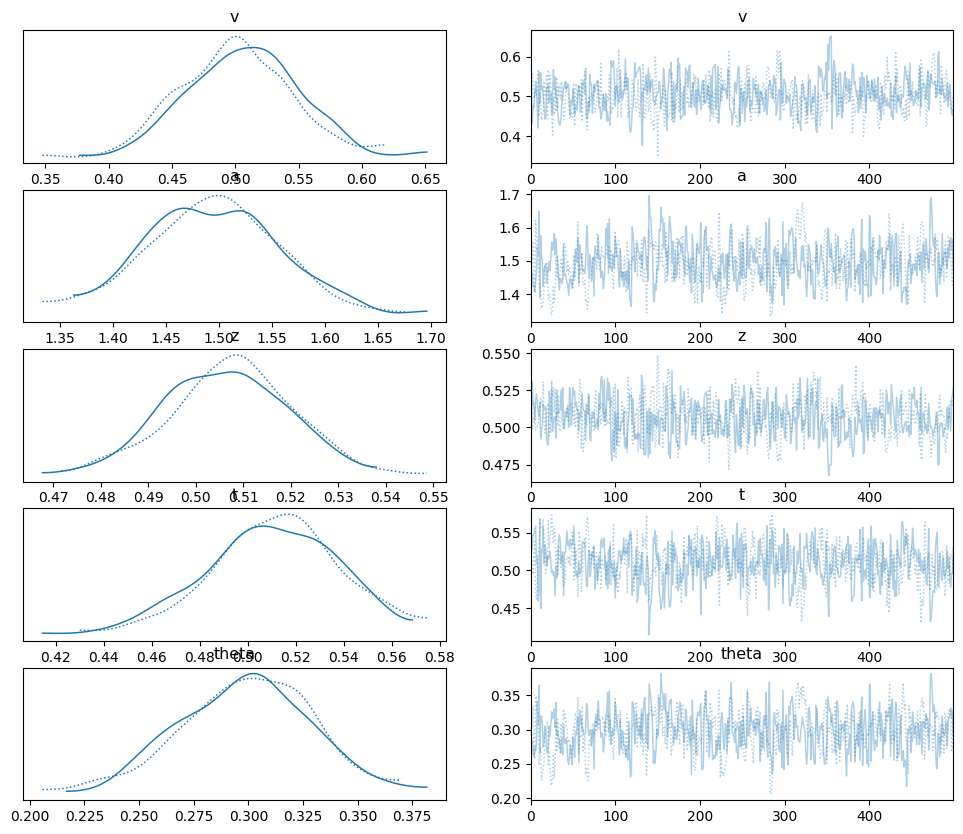

In [19]:
az.plot_trace(trace_angle_nuts_aesara_numpyro)